<a href="https://colab.research.google.com/github/Jaseelkt007/ML/blob/master/JPEG_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## JPEG Compression basics
 JPEG uses a change of basis idea to compress images, and specifically it uses the Discrete Cosine Transform (DCT) to achieve this


 1. Image Preparation
Load a high-resolution RGB image (e.g., 1920×1080).

Convert the RGB to YCbCr color space because human eyes are less sensitive to chroma.

Focus initially on just the Y channel (luminance), for simplicity.

2. Divide into 8×8 Patches
Divide the image into non-overlapping 8×8 blocks (on the Y channel first).

Each 8×8 patch becomes a matrix of pixel intensities.

3. Apply DCT
For each 8×8 block, apply the 2D DCT.

This transforms the spatial domain into the frequency domain.

Low frequencies are concentrated in the top-left corner.

4. Quantization
Apply quantization using a quantization matrix (more aggressive on higher frequencies).

This step reduces many coefficients to zero.

5. Compression
Flatten each block in a zig-zag order (low to high frequency).

Encode using something like run-length encoding (RLE) or Huffman coding.

You now have JPEG-style compression

## First Lets check Compression using FFT instead of DCT and its effect , how much file is reduced

(1280, 1920)


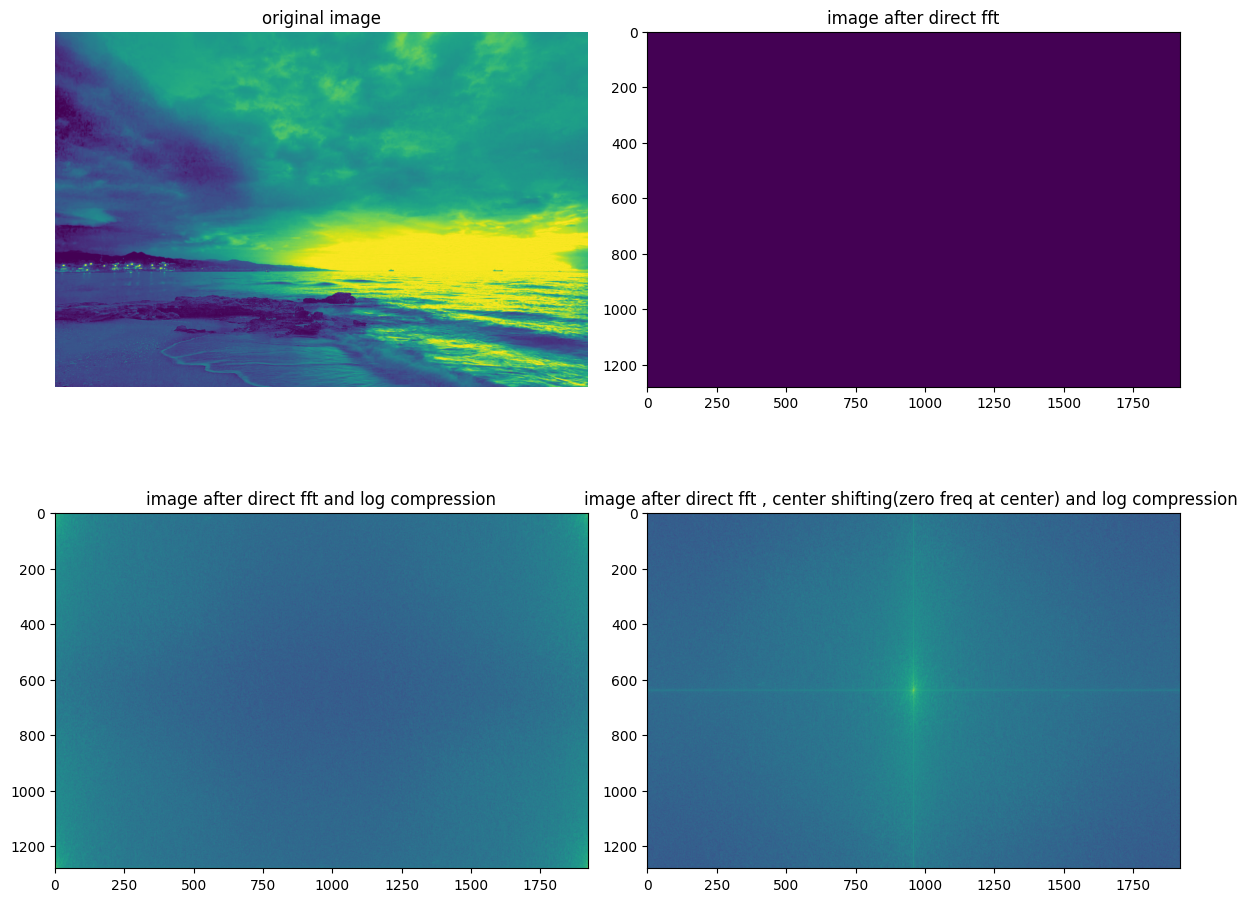

max value in log is  19.93919689178718


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('image_comp.jpg').convert('RGB')
image= np.array(image)

R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
print(R.shape)


coefficents = np.fft.fft2(B)
log_coefficents = np.log1p(np.abs(coefficents)) # apply to compress the high dynamic range of fft

# When FFT is applied, the low frequency or zero frequency components are placed at the top left corner of the result and frequency increase towards the edges
'''
+ve Rotating counter clock wise
F = [ 0, +x, -0, -x]  Top right : High freq x, low y
    [+y, +xy, -y, -xy]
    [-0, -x, -0, -x]
    [-y, -xy, +y, +xy]

np.abs(F) --> remove the phase(angle) info, ie, positive = negative frequency, thats why in visualization , it looks symmetric
'''
# But for visualization purpose we move zero frequency component to center of the spectrum and high frequency radiate from the center to create more intuitive visualization

coefficents_shifted = np.fft.fftshift(coefficents) # Center the zero frequency
log_coef_shifted = np.log1p(np.abs(coefficents_shifted))

plt.figure(figsize=(12,10))
plt.subplot(2,2,1) # 2 rows, 2 columns , 1st position -> top left
plt.title("original image")
plt.imshow(R)
plt.axis('off')

plt.subplot(2,2,2) # top right
plt.title("image after direct fft")
plt.imshow(np.abs(coefficents))

plt.subplot(2,2,3) # bottom left
plt.title("image after direct fft and log compression")
plt.imshow(log_coefficents)

plt.subplot(2,2,4) # bottom right
'''After fftshift: This is only do VISUALIZATION PURPOSE not for compression
[high freq | low freq | high freq]
[low freq  |   DC     | low freq ]
[high freq | low freq | high freq]
'''
plt.title("image after direct fft , center shifting(zero freq at center) and log compression ")
plt.imshow(log_coef_shifted)

plt.tight_layout()  # Adjusts spacing between subplots
plt.show()

# the absolute FFT coefficents have an extremely wide dynamic range
# FFT values are higher for low frequencies and low for high frequencies
print("max value in log is ", np.max(np.abs(log_coefficents)))

Now Try to reconstruct the original image:
1. P = WC , here W is the inverse Fourier basis
2. C = W.t P , Fourier transform of P to get coefficent.

1. without compression
2. with compression

[[216. 215. 214. ... 236. 236. 235.]
 [217. 215. 213. ... 238. 238. 237.]
 [217. 216. 212. ... 239. 239. 238.]
 ...
 [ 75.  92.  97. ... 132. 129. 124.]
 [122. 120. 118. ... 124. 131. 133.]
 [128. 126. 133. ... 132. 130. 124.]]


Text(0.5, 1.0, 'reconstructed')

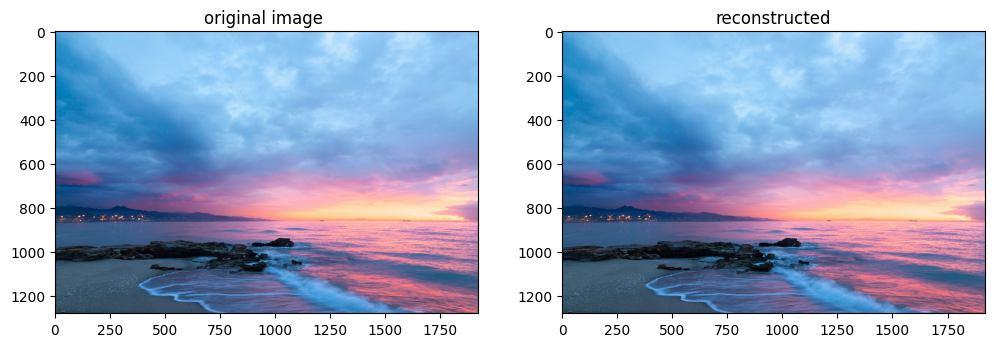

In [ ]:
from PIL import Image

image_reconstructed = np.fft.ifft2(coefficents)
# the result may contain small complex parts due to finite precision . Note : FFT is not ill-conditioned — it’s a well-behaved, orthogonal basis transform (unitary)
print(image_reconstructed.real)

image = Image.open('image_comp.jpg').convert('RGB')
image= np.array(image)

R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
coefficents_R , coefficents_G , coefficents_B = np.fft.fft2(R) ,np.fft.fft2(G) ,np.fft.fft2(B)
rec_R , rec_G, rec_B = np.fft.ifft2(coefficents_R) ,np.fft.ifft2(coefficents_G) ,np.fft.ifft2(coefficents_B)

image_rec_R = np.clip(rec_R.real,0,255).astype(np.uint8) # converted from float64 to uint8 cause many libraries like matplot, PIL expect uint8 for proper rendering
image_rec_G = np.clip(rec_G.real,0,255).astype(np.uint8)
image_rec_B = np.clip(rec_B.real,0,255).astype(np.uint8)
image_rec = np.stack([image_rec_R,image_rec_G,image_rec_B],axis=2) # (H, W, Channel)- for PIL ,matplot


# save the image for comparison
Image.fromarray(image_rec).save("reconstructed.png") # Saving it as png for Lossless saving ,will have larger file size
# 1920 *1080 *3 = 6220800 , 6220800*1 bytes (uint8) => 6220800/(1024kb*1024mb) = 5.93MB , PNG then compress this lossless way

# Save it in pure raw(Pure Binary Data) , no compression involed , so ~6MB
'''image_rec.tofile("reconstructed_raw.raw")''' # this is just a flat byte array means 1D array or a vector of size 1280*1920 each value is 8bit binary values: 1 byte per channel per pixel
'''
raw_data = np.fromfile('reconstructed_raw.raw', dtype=np.uint8)
image_r = raw_data.reshape((1280,1920,3))'''

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("original image ")
plt.subplot(1,2,2)
plt.imshow(image_rec)
plt.title("reconstructed")



#Now lets do Threshold part after FFT
There are many ways strategies for Compression strategy : means filter out some coeficents
1. Keep only top-k % strongest frequencies
2. Keep only a central square in fftshifted

Resolution is not changed here, Quality and Sharpness and details are changed
1. Original image: 1920×1080 pixels = 2M pixels × 3 channels => FFT result: 1920×1080 complex coefficients
2. for eg: Zero out 80% of the coefficients, and Only store or transmit the remaining 20% --> After thresholding, you have a sparse matrix (mostly zeros)

still 0 is also counted to memory for eg: [0,0,255,128] -> 4 bytes, and [0,0,0,0,] -> still 4 bytes, so to reduce the size we have to some compresion algorithm techniques to represent it more efficently


original image size :  365.9091796875 KB
Compressed fft size: 1140.7890625 KB
indices_R shape: (2, 24576)
First few indices of indices_R: [0 0 0 0 0 0 0 0 0 0]
mean absolute errror 0.5062794325086806


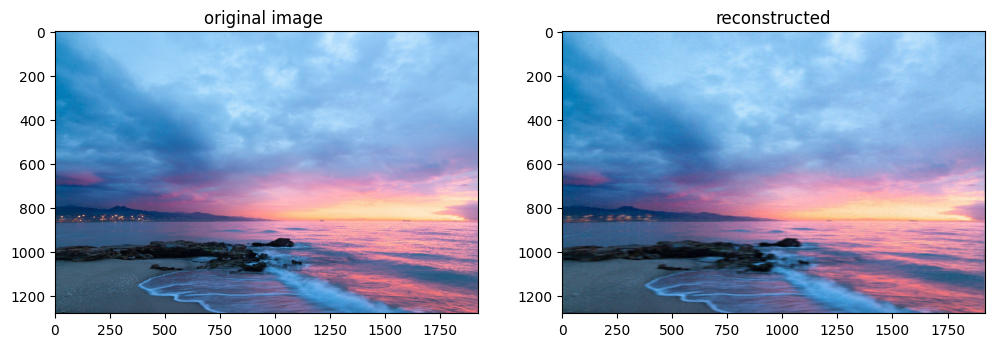

In [ ]:
image = Image.open('image_comp.jpg').convert('RGB')
image= np.array(image)
R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
coefficents_R , coefficents_G , coefficents_B = np.fft.fft2(R) ,np.fft.fft2(G) ,np.fft.fft2(B)

# 1. 80% filterout: Out of all the FFT coefficients, we’re keeping only the top 20% most energetic ones
'''
Lower Frequencies : top left of fft -> capture overall structure, smooth gradient , brightness => Higher in magnitude
Higher Frequencies : corner of fft -> capture, fine details, noise, sharp edges, => Small in magnitude

Note: Higher magnitude coefficients usually correspond to low frequencies but can also some high frequency component too
Threshold for Keeping the top 20% of coefficients by magnitude
'''

threshold_R = np.percentile(np.abs(coefficents_R),99) # compute the 80th percentile value of this 2D array = scalar value
threshold_G = np.percentile(np.abs(coefficents_G),99)
threshold_B = np.percentile(np.abs(coefficents_B),99)

mask_R = np.abs(coefficents_R) >= threshold_R # create masks for filterout to keep only the higher energetic frequencies (top 20% frequencies in magnitude, mostly low frequencies)
mask_G = np.abs(coefficents_G) >= threshold_G
mask_B = np.abs(coefficents_B) >= threshold_B

# Apply the mask
coefficent_R_comp = coefficents_R * mask_R
coefficent_G_comp = coefficents_G * mask_G
coefficent_B_comp = coefficents_B * mask_B

# Reconstruct
image_recon_R , image_recon_G ,image_recon_B= np.fft.ifft2(coefficent_R_comp).real , np.fft.ifft2(coefficent_G_comp).real ,np.fft.ifft2(coefficent_B_comp).real
image_recon_R , image_recon_G ,image_recon_B = np.clip(image_recon_R,0,255).astype(np.uint8),np.clip(image_recon_G,0,255).astype(np.uint8) , np.clip(image_recon_B,0,255).astype(np.uint8)
image_recon = np.stack([image_recon_R,image_recon_G,image_recon_B], axis =2)

# Now save it, take only the non zero FFt values, for storing
indices_R = np.nonzero(mask_R) # return a tuple( row_indices , col_indices)
indices_G = np.nonzero(mask_G)
indices_B = np.nonzero(mask_B)

values_R = coefficents_R[indices_R]
values_G = coefficents_G[indices_G]
values_B = coefficents_B[indices_B]

# we are going to use ZIP compression algorithm for numpy arrays to store all non zero values,
np.savez_compressed(
    "compressed_RGB.npz",indices_R= indices_R, values_R=values_R, shape_R = coefficents_R.shape,
    indices_G= indices_G, values_G=values_G, shape_G = coefficents_G.shape,
    indices_B= indices_B, values_B=values_B, shape_B = coefficents_B.shape,

)

# Check the file size difference
import os
print("original image size : ", os.path.getsize('image_comp.jpg')/1024,"KB")
print("Compressed fft size:", os.path.getsize('compressed_RGB.npz')/1024, "KB")

# Now lets do the reconstruction from the compressed file.
'''
1. Load the compressed file to open .npz archive
2. Retrieve the indices and values, and shape for R, G, B from the archeive
3. Reconstruct the full FFT coefficient means create a new zero filled arrays with original shape
4. Apply inverse FFT on the reconstructed coefficent arrays for each channel and take the real part
5. clip them to 0 -255, then stack them together
'''

data = np.load("compressed_RGB.npz")
indices_R = data["indices_R"] # tuple with (row , column) for R channel
print("indices_R shape:", indices_R.shape)
print("First few indices of indices_R:", indices_R[0][:10])
values_R = data["values_R"] # stored FFT coefficents
shape_R = tuple(data["shape_R"])

# Similarly for G and B channel
indices_G = data["indices_G"]
values_G  = data["values_G"]
shape_G   = tuple(data["shape_G"])

indices_B = data["indices_B"]
values_B  = data["values_B"]
shape_B   = tuple(data["shape_B"])

# Reconstruct full FFT arrays for each channel
coef_R_full = np.zeros(shape_R, dtype=complex)
coef_R_full[tuple(indices_R)] = values_R

coef_G_full = np.zeros(shape_G, dtype=complex)
coef_G_full[tuple(indices_G)] = values_G

coef_B_full = np.zeros(shape_B, dtype=complex)
coef_B_full[tuple(indices_B)] = values_B

# Inverse FFt to obtain each channel color code.
R_rec = np.fft.ifft2(coef_R_full).real
G_rec = np.fft.ifft2(coef_G_full).real
B_rec = np.fft.ifft2(coef_B_full).real

# Clip and stack
R_rec, G_rec, B_rec = np.clip(R_rec, 0,255).astype(np.uint8) ,np.clip(G_rec, 0,255).astype(np.uint8),np.clip(B_rec, 0,255).astype(np.uint8)
reconst_image = np.stack([R_rec, G_rec, B_rec], axis=2)




plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("original image ")
plt.subplot(1,2,2)
plt.imshow(reconst_image)
plt.title("reconstructed")
mae = np.mean((np.abs(image.astype(np.float64)))-(np.abs(image_recon.astype(np.float64))))
print("mean absolute errror", mae)



## Now Lets apply DCT and see its effect
The DCT is specially designed for image compression, concentrating most of the image’s energy into a few coefficients

1. in FFT method, even though we discard 99% of the coefficents , we still need to store the indices (row and columns positions) for remaining coefficents,
These indices add overhead, which can significantly contribute to the file size
2. In JPEG , the quantized coefficents are arranged in a predictable order (using zig-zag scanning) and then efficent entropy coding, so there is not extra overhead like explicit indices
3. since FFT is complex values, to apply JPEG like quantization and entropy coding is extra complexity, since DCT is real valued , its easy there


max value dct values :R 196007.07077445343


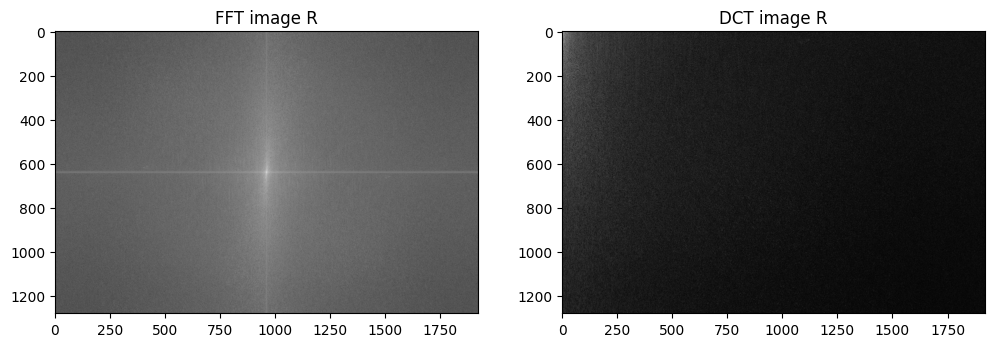

In [ ]:
# Lets Visualize DCT and compare it to FFT
from scipy.fft import dctn

image = Image.open('image_comp.jpg').convert("RGB")
image = np.array(image)
R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
fft_coef_R , fft_coef_G , fft_coef_B = np.fft.fft2(R) ,np.fft.fft2(G) ,np.fft.fft2(B)

dct_coef_R, dct_coef_G , dct_coef_B = dctn(R, norm='ortho') , dctn(G, norm='ortho') , dctn(B, norm='ortho')
# DCT coefficents starts with low frequency(DC) at the top left
# frequency increase row wise and column wise
print("max value dct values :R",np.max(dct_coef_R) )

# # let me do center shifting for DCT for expirement
# dct_R = np.fft.fftshift(dct_coef_R)
# dct_R = np.log1p(np.abs(dct_R))

# Lets do log compression as for DCT
dct_coef_R, dct_coef_G , dct_coef_B = np.log1p(np.abs(dct_coef_R)) ,np.log1p(np.abs(dct_coef_G)) ,np.log1p(np.abs(dct_coef_B))
'''
DCT Already Orders Frequencies Top-Left → Bottom-Right
DCT is already laid out logically and spatially — no shift is needed.
This is one big reason why JPEG uses DCT instead of FFT ie, The DCT output is naturally organized for quantization
'''
# for visualization
fft_coef_R_shift , fft_coef_G_shift , fft_coef_B_shift = np.fft.fftshift(fft_coef_R) ,np.fft.fftshift(fft_coef_G) ,np.fft.fftshift(fft_coef_B)
fft_R , fft_G, fft_B = np.log1p(np.abs(fft_coef_R_shift)) , np.log1p(np.abs(fft_coef_G_shift)) ,np.log1p(np.abs(fft_coef_B_shift))


plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.title("FFT image R")
plt.imshow(fft_R,cmap='gray')

plt.subplot(2,2,2)
plt.title("DCT image R")
plt.imshow(dct_coef_R,cmap='gray')

In [79]:
from scipy.fft import dctn # 2D DCT

image = Image.open('image_comp.jpg').convert("RGB")
image = np.array(image)
R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
H, W,C = image.shape
H_padded = (H+7)//8 *8 # padding to make image size multiple of 8
W_padded = (W + 7)//8 *8
padded_image = np.zeros((H_padded, W_padded,C), dtype=image.dtype)
padded_image[:H, :W,:] = image # copy the image to padded image
image = padded_image
R , G , B = image[:,:,0], image[: ,:,1], image[:,:,2]
#dct_coef_R, dct_coef_G , dct_coef_B = dctn(R, norm='ortho') , dctn(G, norm='ortho') , dctn(B, norm='ortho')

# Apply DCT block wise
def dct_block_wise(channel):
    H, W = channel.shape
    dct_full_channel = np.zeros_like(channel)
    for i in range(0,H,8):
        for j in range(0,W, 8):
            block = channel[i:i+8, j:j+8]
            dct_full_channel[i:i+8,j:j+8]=dctn(block, norm='ortho')
    return dct_full_channel

dct_coef_R = dct_block_wise(R)
dct_coef_G = dct_block_wise(G)
dct_coef_B = dct_block_wise(B)

# we can either use JPEG quantization matrix or thresholding as in FFT
jpeg_quant_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
  [12, 12, 14, 19, 26, 58, 60, 55],
  [14, 13, 16, 24, 40, 57, 69, 56],
  [14, 17, 22, 29, 51, 87, 80, 62],
  [18, 22, 37, 56, 68, 109, 103, 77],
  [24, 35, 55, 64, 81, 104, 113, 92],
  [49, 64, 78, 87, 103, 121, 120, 101],
  [72, 92, 95, 98, 112, 100, 103, 99]
]) # 8*8 matrix tuned for human perception , and apply to each 8*8 DCT block

print("shape of dct_coef_R: ",dct_coef_R.shape )
def quantize_channel(dct_channel):
    quantized_block = np.zeros(dct_channel.shape)
    for i in range(0,dct_channel.shape[0],8):
      for j in range(0,dct_channel.shape[1],8):
        block = dct_channel[i : i+8, j: j+8]
        if block.shape == (8, 8): # safety check
          quantized_block[i:i+8, j:j+8] = np.round(block/jpeg_quant_matrix)
    return quantized_block

q_R = quantize_channel(dct_coef_R)
q_G = quantize_channel(dct_coef_G)
q_B = quantize_channel(dct_coef_B)
print("shape of q_R is : ", q_R.shape)
# print("few contents before quantization 5*5", dct_coef_R[:5,:5])
# print("few contents of q_R 5*5:", q_R[:8,:8])
print("non zero values in q_R", np.count_nonzero(q_R))

# increase sparcisity
# threshold = 2
# q_R[np.abs(q_R) < threshold]=0
# q_G[np.abs(q_G) < threshold] = 0
# q_B[np.abs(q_B) < threshold] = 0

# Lets use ZIP compression , and check whether it reduces file size btw fft method, to see how sparse DCT quantized matrix is
# np.savez_compressed("filename.npz", key1=array1, key2=array2, ...)
np.savez_compressed("quantized_dct_full.npz", q_R = q_R, q_G=q_G, q_B=q_B )

# Check the file size difference
import os
print("compressed fft size : ", os.path.getsize('compressed_RGB.npz')/1024,"KB")
print("Compressed dct size:", os.path.getsize('quantized_dct_full.npz')/1024, "KB")




shape of dct_coef_R:  (1280, 1920)
shape of q_R is :  (1280, 1920)
non zero values in q_R 400287
compressed fft size :  1140.7890625 KB
Compressed dct size: 1790.94921875 KB


# compare the reconstructed image of FFT and DCT
1. From DCT compression and threshold and even using ZIP compression, file size is significantly reduced

shape of R_recon (1280, 1920)


(np.float64(-0.5), np.float64(1919.5), np.float64(1279.5), np.float64(-0.5))

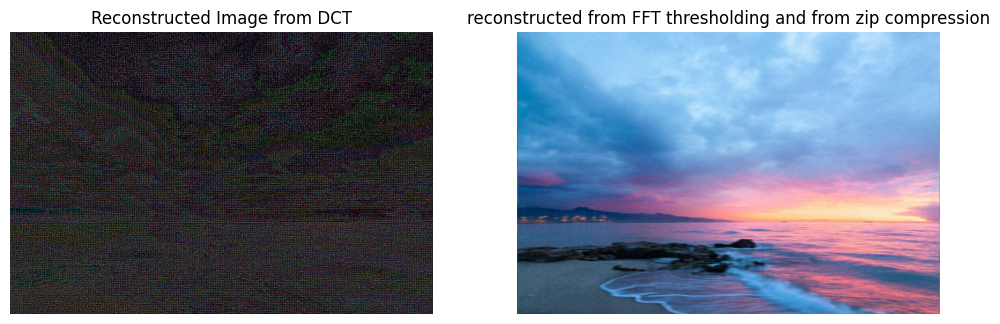

In [80]:
from scipy.fft import idctn

data_dct = np.load("quantized_dct_full.npz")
q_R = data_dct["q_R"] # load the array back
q_G = data_dct["q_G"]
q_B = data_dct["q_B"]

# Do dequantization
def dequantization_and_idct(q_channel):
    H, W = q_channel.shape
    recon = np.zeros_like(q_channel)
    for i in range(0, H, 8):
        for j in range(0, W, 8):
            block = q_channel[i:i+8, j:j+8]
            if block.shape == (8, 8):
                dequantize_block = block * jpeg_quant_matrix
                idct_block = idctn(dequantize_block, norm='ortho')
                recon[i:i+8, j:j+8] = idct_block
    return recon

R_recon = dequantization_and_idct(q_R)
G_recon = dequantization_and_idct(q_G)
B_recon = dequantization_and_idct(q_B)

print("shape of R_recon", R_recon.shape)
recon = np.stack([R_recon,G_recon,B_recon], axis=2)
recon = np.clip(recon, 0,255).astype(np.uint8)

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.imshow(recon)
plt.title("Reconstructed Image from DCT")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(reconst_image)
plt.title("reconstructed from FFT thresholding and from zip compression")
plt.axis("off")


This result is expected,cause the Real JPEG uses several additional steps and carefully tuned parameters, that is missing here
following things are missing.
1. No DC Offset (Level Shift) Before DCT
2. No YCbCr Color Transform
3. No aggressive thresholding
4. No Entropy coding or zig zag scan - but this is only for the compression part

In [85]:
# Use YCbCr instead of RGB
image = Image.open('image_comp.jpg').convert("YCbCr")
image = np.array(image)
Y , Cb , Cr = image[:,:,0], image[: ,:,1], image[:,:,2]
H, W,C = image.shape
H_padded = (H+7)//8 *8 # padding to make image size multiple of 8
W_padded = (W + 7)//8 *8
padded_image = np.zeros((H_padded, W_padded,C), dtype=image.dtype)
padded_image[:H, :W,:] = image # copy the image to padded image
image = padded_image
Y , Cb , Cr = image[:,:,0], image[: ,:,1], image[:,:,2]

# Apply DCT block wise , using level shifting, to [0,255] to [-128,+127]
def dct_block_wise(channel):
    H, W = channel.shape
    dct_full_channel = np.zeros_like(channel)
    for i in range(0, H, 8):
        for j in range(0, W, 8):
            block = channel[i:i+8, j:j+8] - 128  # Level shift [0,255] → [-128, +127]
            dct_full_channel[i:i+8, j:j+8] = dctn(block, norm='ortho')
    return dct_full_channel

dct_coef_Y = dct_block_wise(Y)
dct_coef_Cb = dct_block_wise(Cb)
dct_coef_Cr = dct_block_wise(Cr)

def quantize_channel(dct_channel):
    quantized_block = np.zeros(dct_channel.shape)
    for i in range(0,dct_channel.shape[0],8):
      for j in range(0,dct_channel.shape[1],8):
        block = dct_channel[i : i+8, j: j+8]
        if block.shape == (8, 8): # safety check
          quantized_block[i:i+8, j:j+8] = np.round(block/jpeg_quant_matrix)
    return quantized_block

q_R = quantize_channel(dct_coef_Y)
q_G = quantize_channel(dct_coef_Cb)
q_B = quantize_channel(dct_coef_Cr)

# Lets use ZIP compression , and check whether it reduces file size btw fft method, to see how sparse DCT quantized matrix is
# np.savez_compressed("filename.npz", key1=array1, key2=array2, ...)
np.savez_compressed("quantized_dct_full.npz", q_R = q_R, q_G=q_G, q_B=q_B )

# Check the file size difference
import os
print("compressed fft size : ", os.path.getsize('compressed_RGB.npz')/1024,"KB")
print("Compressed dct size:", os.path.getsize('quantized_dct_full.npz')/1024, "KB")




compressed fft size :  1140.7890625 KB
Compressed dct size: 1556.4189453125 KB


shape of R_recon (1280, 1920)


(np.float64(-0.5), np.float64(1919.5), np.float64(1279.5), np.float64(-0.5))

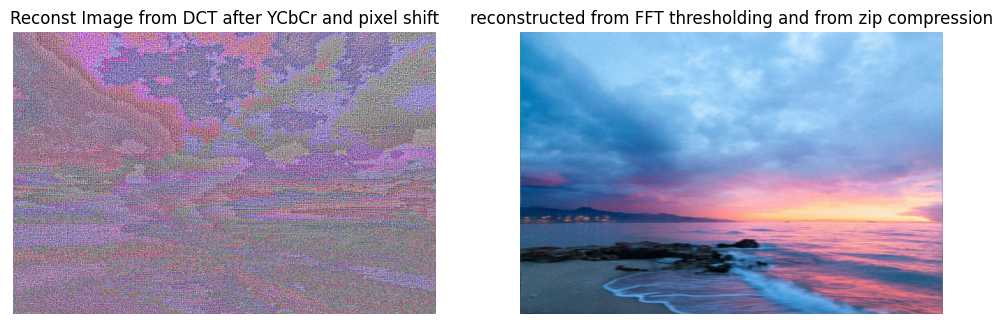

In [86]:
# Reconstruction:
from scipy.fft import idctn

data_dct = np.load("quantized_dct_full.npz")
q_Y = data_dct["q_R"] # load the array back
q_Cb = data_dct["q_G"]
q_Cr = data_dct["q_B"]

# Do dequantization
def dequantization_and_idct(q_channel):
    H, W = q_channel.shape
    recon = np.zeros_like(q_channel)
    for i in range(0, H, 8):
        for j in range(0, W, 8):
            block = q_channel[i:i+8, j:j+8]
            if block.shape == (8, 8):
                dequantize_block = block * jpeg_quant_matrix
                idct_block = idctn(dequantize_block, norm='ortho')
                recon[i:i+8, j:j+8] = idct_block + 128  # Undo level shift
    return recon

Y_recon = dequantization_and_idct(q_Y)
Cb_recon = dequantization_and_idct(q_Cb)
Cr_recon = dequantization_and_idct(q_Cr)

print("shape of R_recon", Y_recon.shape)
Y_recon = np.clip(Y_recon, 0, 255).astype(np.uint8)
Cb_recon = np.clip(Cb_recon, 0, 255).astype(np.uint8)
Cr_recon = np.clip(Cr_recon, 0, 255).astype(np.uint8)

recon_ycbcr = np.stack([Y_recon,Cb_recon,Cr_recon], axis=2)

# CONVERT YCbCr to RGb
recon = Image.fromarray(recon_ycbcr, mode='YCbCr').convert('RGB')


plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.imshow(recon)
plt.title("Reconst Image from DCT after YCbCr and pixel shift")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(reconst_image)
plt.title("reconstructed from FFT thresholding and from zip compression")
plt.axis("off")